## Introduction

From TMDB movie dataset, I analyst:
* areas have the most influence on revenue
* how genre effect movie's revenue and average score
* release date effect to revenue

The credits dataset contains the following features:-
* movie_id - A unique identifier for each movie.
* cast - The name of lead and supporting actors.
* crew - The name of Director, Editor, Composer, Writer etc.

The movies dataset has the following features:-
* budget - The budget in which the movie was made.
* genre - The genre of the movie, Action, Comedy ,Thriller etc.
* homepage - A link to the homepage of the movie.
* id - This is infact the movie_id as in the first dataset.
* keywords - The keywords or tags related to the movie.
* original_language - The language in which the movie was made.
* original_title - The title of the movie before translation or adaptation.
* overview - A brief description of the movie.
* popularity - A numeric quantity specifying the movie popularity.
* production_companies - The production house of the movie.
* production_countries - The country in which it was produced.
* release_date - The date on which it was released.
* revenue - The worldwide revenue generated by the movie.
* runtime - The running time of the movie in minutes.
* status - "Released" or "Rumored".
* tagline - Movie's tagline.
* title - Title of the movie.
* vote_average - average ratings the movie recieved.
* vote_count - the count of votes recieved.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import plotly.express as px
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

## Describing the data

Load dataset and change format json in some column

In [2]:
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df= df[['genres','production_countries', 'revenue', 'release_date', 'vote_average','title']]
    #df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())  
    df.rename(columns={"production_countries":"areas"},inplace = True)
    json_columns = ['genres', 'areas']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
        for index,i in zip(df.index,df[column]):
            list1=[]
            for j in range(len(i)):
                list1.append((i[j]['name']))# the key 'name' contains the name of the genre
            df.loc[index,column]=str(list1)  
        df[column]=df[column].str.strip('[]').str.replace("'",'').str.replace(" ",'')
        df[column]=df[column].str.split(',')
    return df

def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

movies = load_tmdb_movies("movieDataset/tmdb_5000_movies.csv")
movies.head()

,genres,areas,revenue,release_date,vote_average,title
0,"[Action, Adventure, Fantasy, ScienceFiction]","[UnitedStatesofAmerica, UnitedKingdom]",2787965087,2009-12-10,7.2,Avatar
1,"[Adventure, Fantasy, Action]",[UnitedStatesofAmerica],961000000,2007-05-19,6.9,Pirates of the Caribbean: At World's End
2,"[Action, Adventure, Crime]","[UnitedKingdom, UnitedStatesofAmerica]",880674609,2015-10-26,6.3,Spectre
3,"[Action, Crime, Drama, Thriller]",[UnitedStatesofAmerica],1084939099,2012-07-16,7.6,The Dark Knight Rises
4,"[Action, Adventure, ScienceFiction]",[UnitedStatesofAmerica],284139100,2012-03-07,6.1,John Carter


In [3]:
movies.shape

(4803, 6)

### Check missing value and remove them

In [4]:
totalMissing = movies.isnull().sum()
count = movies.isnull().count()
percentMissing = (movies.isnull().sum()/movies.isnull().count())
missing_data = pd.concat([totalMissing, percentMissing],axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
genres,0,0.000000
areas,0,0.000000
revenue,0,0.000000
release_date,1,0.000208
vote_average,0,0.000000


Based on above table, null data don't have or very few, so we stay the same

### Descriptive statistic of data

In [5]:
movies.describe()

,revenue,vote_average
count,4.803000e+03,4803.000000
mean,8.226064e+07,6.092172
std,1.628571e+08,1.194612
min,0.000000e+00,0.000000
25%,0.000000e+00,5.600000
50%,1.917000e+07,6.200000
75%,9.291719e+07,6.800000
max,2.787965e+09,10.000000


In [6]:
movies.describe(include='O')

,genres,areas,release_date,title
count,4803,4803,4802,4803
unique,1175,469,3280,4800
top,[Drama],[UnitedStatesofAmerica],2006-01-01,The Host
freq,370,2977,10,2


## Filtering data

none

In [7]:
#list from column have format json to do list 
def createDic(name):
    alist = {}
    for index, row in movies.iterrows():
        names = row[name]
        for n in names:
            if (n not in alist) :
                alist[n]=[]
    return alist


## Visualization

have explained analysis followed

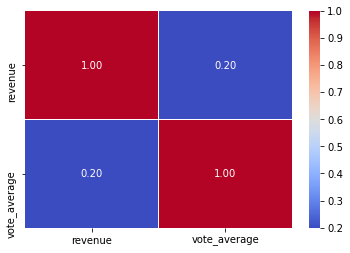

In [8]:
#correlation
g = sns.heatmap(movies[list(movies)].corr(),annot=True, fmt = ".2f", cmap = "coolwarm",linewidths= 0.01)

From heatmap, vote_average have few impact to revenue

#### Effect by areas to revenue

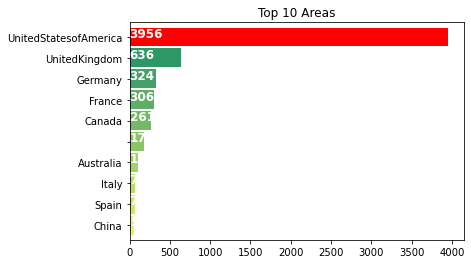

In [9]:
#visualize top 10 areas have the most revenue
list1=[]
for i in movies['areas']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('summer_r',10))
for i, v in enumerate(pd.Series(list1).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
ax.patches[9].set_facecolor('r')
plt.title('Top 10 Areas')
plt.show()

From plot, we can see that US have the highest revenue
Now, we prove impact

## Analysis

##### ANALYSIS AREAS AND REVENUE

In [10]:
#list areas
areaDic = createDic('areas')
for i in range(movies.shape[0]):
    for j in range(len(movies.areas[i])):
        areaDic[movies['areas'][i][j]].append(movies['revenue'][i])
areaDic

{'UnitedStatesofAmerica': [2787965087,
  961000000,
  880674609,
  1084939099,
  284139100,
  890871626,
  591794936,
  1405403694,
  933959197,
  873260194,
  391081192,
  586090727,
  1065659812,
  89289910,
  662845518,
  419651413,
  1519557910,
  1045713802,
  624026776,
  956019788,
  752215857,
  310669540,
  958400000,
  372234864,
  550000000,
  1845034188,
  1153304495,
  303025485,
  1513528810,
  1108561013,
  783766341,
  1215439994,
  1025491110,
  459359555,
  743559607,
  836297228,
  1091405097,
  491868548,
  705717432,
  400062763,
  559852396,
  219851172,
  1066969703,
  371353001,
  1506249360,
  531865000,
  747862775,
  467365246,
  197687603,
  351040419,
  335154643,
  407602906,
  1123746996,
  786636033,
  331926147,
  538983207,
  343471816,
  521311860,
  258022233,
  769653595,
  325233863,
  183987723,
  356743061,
  748806957,
  543934787,
  1004558444,
  735099082,
  381509870,
  585174222,
  185770160,
  222104681,
  401128639,
  745000000,
  17300000

In [11]:
#hepothesis revenue and areas
f_oneway(areaDic['UnitedStatesofAmerica'],areaDic['UnitedKingdom'],areaDic['NewZealand'])

F_onewayResult(statistic=17.283708546333674, pvalue=3.3246104235728844e-08)

###### with p_value<0.05 so, we can reject H0 and conclude that Areas have impact to Revenue and the most is US

##### ANALYSIS GENRES AND REVENUE

In [12]:
#Create dictionary include genres, revenue
GeRe=createDic('genres')
for i in range(movies.shape[0]):
    for j in range(len(movies.genres[i])):
        GeRe[movies['genres'][i][j]].append(movies['revenue'][i])
GeRe

{'Action': [2787965087,
  961000000,
  880674609,
  1084939099,
  284139100,
  890871626,
  1405403694,
  873260194,
  391081192,
  586090727,
  1065659812,
  89289910,
  662845518,
  1519557910,
  1045713802,
  624026776,
  956019788,
  752215857,
  310669540,
  550000000,
  1153304495,
  303025485,
  1513528810,
  1108561013,
  783766341,
  1215439994,
  459359555,
  836297228,
  1091405097,
  705717432,
  400062763,
  219851172,
  371353001,
  1506249360,
  531865000,
  747862775,
  467365246,
  197687603,
  335154643,
  407602906,
  1123746996,
  786636033,
  538983207,
  343471816,
  258022233,
  769653595,
  183987723,
  356743061,
  1004558444,
  585174222,
  222104681,
  401128639,
  745000000,
  370541256,
  264218220,
  302469017,
  623933331,
  758539785,
  710644566,
  0,
  150962475,
  714766572,
  652105443,
  389681935,
  435000000,
  773328629,
  825532764,
  77000000,
  1021103568,
  207283925,
  353624124,
  653428261,
  215283742,
  181674817,
  433677183,
  44060353

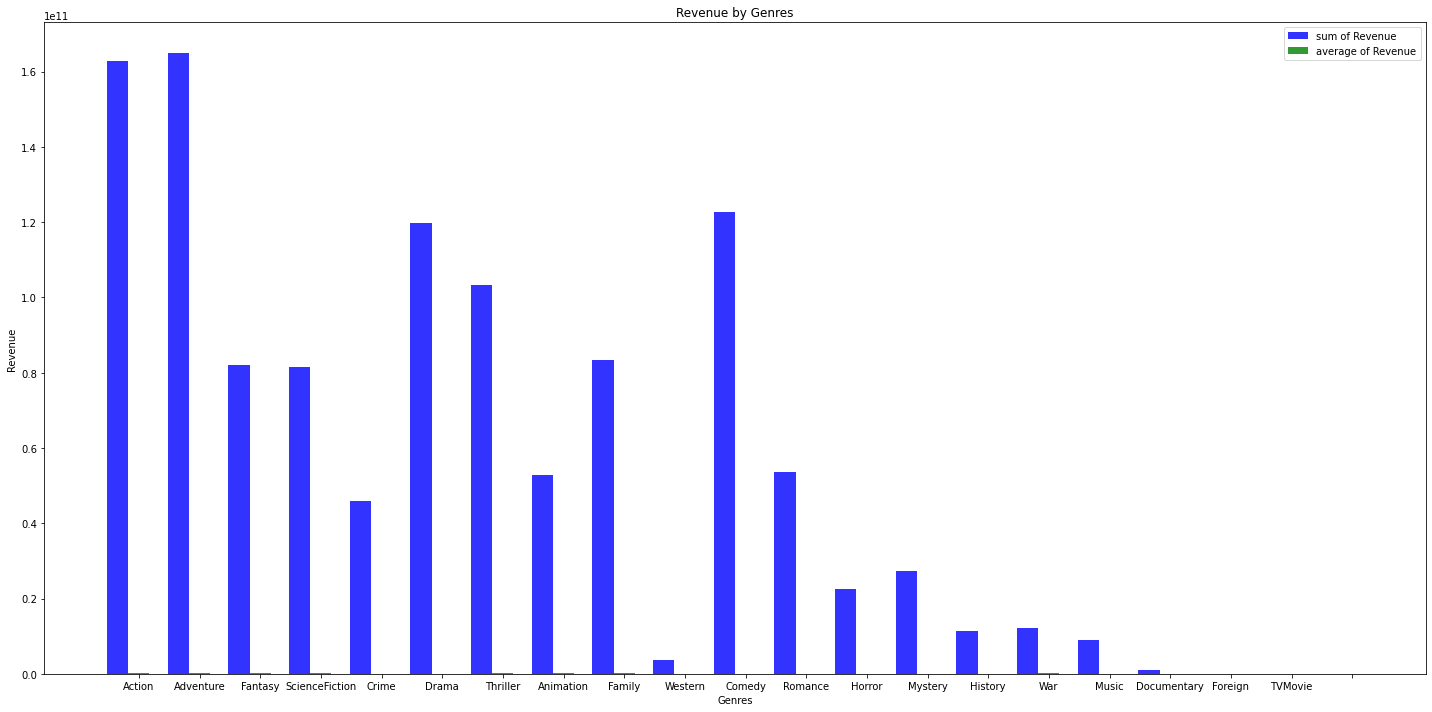

In [14]:
n_groups = len(GeRe)
sumRevenue =[]
averageRe =[]
for index,values in enumerate(GeRe):
    sumRevenue.append(sum(GeRe[values]))
    averageRe.append(int(sum(GeRe[values])/len(GeRe[values])))

# create plot
fig, ax = plt.subplots(figsize=(20, 10))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, sumRevenue, bar_width,
alpha=opacity,
color='b',
label='sum of Revenue')

rects2 = plt.bar(index + bar_width, averageRe, bar_width,
alpha=opacity,
color='g',
label='average of Revenue')

plt.xlabel('Genres')
plt.ylabel('Revenue')
plt.title('Revenue by Genres')
plt.xticks(index + bar_width, list(GeRe))
plt.legend()

plt.tight_layout()
plt.show()

We can see that, have difference in Revenue of genres. So we testing

In [15]:
#hepothesis revevue and genres
f_oneway(GeRe['Action'],GeRe['Drama'], GeRe['Adventure'])

F_onewayResult(statistic=228.18269936809654, pvalue=7.631780947237442e-95)

From above, we can reject H0 and conclude that Genres have impact to Revenue, and Adventure, Action have the highest revenue

##### ANALYSIS GENRES AND SCORE

In [16]:
#Create dictionary include genres, score_average
GeSc=createDic('genres')
for i in range(movies.shape[0]):
    for j in range(len(movies.genres[i])):
        GeSc[movies['genres'][i][j]].append(movies['vote_average'][i])
GeSc

{'Action': [7.2,
  6.9,
  6.3,
  7.6,
  6.1,
  5.9,
  7.3,
  5.7,
  5.4,
  6.1,
  7.0,
  5.9,
  6.5,
  7.4,
  6.4,
  6.2,
  7.1,
  6.5,
  6.2,
  6.6,
  7.1,
  5.5,
  6.5,
  6.9,
  6.7,
  6.8,
  6.3,
  6.0,
  5.8,
  6.5,
  6.3,
  5.1,
  5.9,
  7.3,
  6.7,
  7.5,
  7.4,
  5.5,
  6.2,
  6.7,
  6.1,
  5.7,
  6.7,
  6.6,
  6.1,
  5.6,
  5.2,
  5.5,
  8.2,
  7.4,
  5.1,
  5.2,
  5.9,
  7.6,
  5.9,
  5.6,
  6.6,
  7.0,
  7.3,
  4.8,
  5.9,
  7.6,
  7.8,
  4.9,
  5.9,
  7.9,
  8.1,
  6.5,
  7.0,
  6.6,
  7.1,
  6.6,
  5.8,
  5.5,
  6.3,
  5.8,
  6.6,
  5.6,
  6.2,
  6.9,
  7.5,
  5.9,
  6.2,
  6.4,
  6.7,
  6.8,
  7.2,
  6.6,
  5.1,
  7.1,
  4.7,
  6.5,
  6.4,
  5.8,
  5.3,
  6.4,
  6.0,
  5.5,
  6.7,
  6.8,
  7.3,
  5.6,
  7.4,
  6.8,
  7.6,
  4.9,
  7.0,
  6.3,
  5.3,
  5.4,
  5.7,
  5.9,
  6.6,
  6.0,
  6.1,
  7.3,
  7.0,
  7.4,
  6.3,
  6.4,
  6.2,
  5.0,
  6.7,
  5.4,
  7.5,
  6.8,
  7.1,
  7.0,
  5.6,
  7.1,
  6.4,
  6.0,
  4.2,
  6.2,
  5.9,
  5.4,
  7.2,
  5.2,
  5.9,
  5.2,
  6.4,
  6

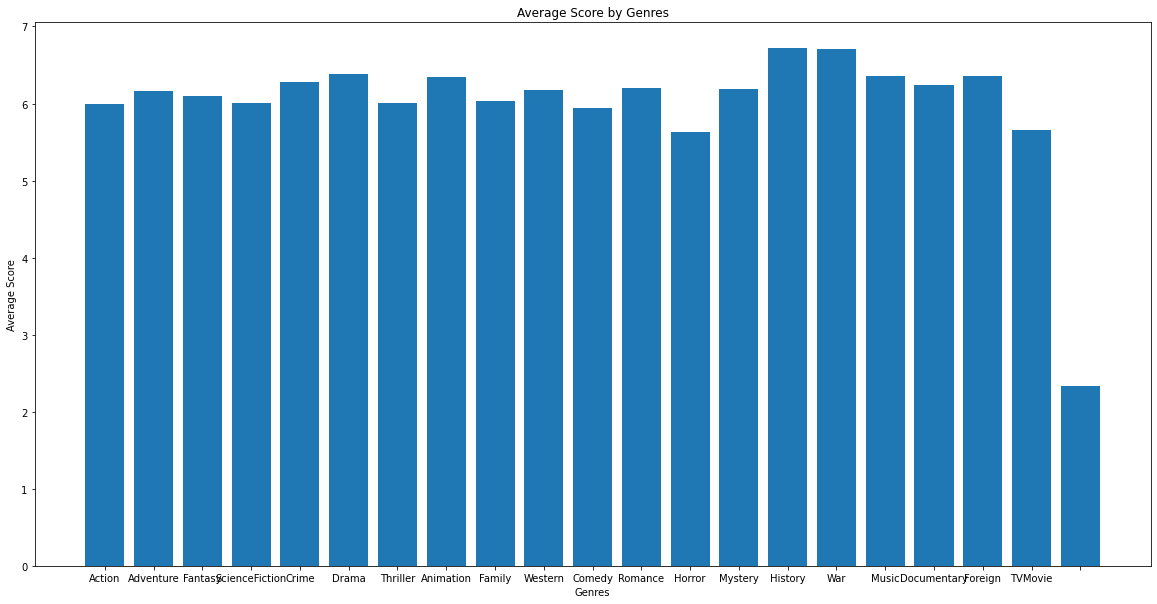

In [17]:
averageSc =[]
for index,values in enumerate(GeSc):
    averageSc.append(sum(GeSc[values])/len(GeSc[values]))

fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(list(GeSc),averageSc)
plt.xlabel('Genres')
plt.ylabel('Average Score')
plt.title('Average Score by Genres')
plt.show()

In [18]:
#hepothesis revevue and genres
f_oneway(GeSc['Action'],GeSc['Drama'], GeSc['Adventure'])

F_onewayResult(statistic=61.24980004448756, pvalue=5.980565092545757e-27)

From above, we can reject H0 and conclude that Genres have impact to Score Average, and History and War have the highest Average Score

##### ANALYSIS RELEASE_DATE AND REVENUE

In [19]:
##Create dictionary include revenue and release_date
DateRe={}
for i in range(movies.shape[0]):
    if movies.release_date[i] not in DateRe:
        DateRe[movies.release_date[i]]=[]
    DateRe[movies['release_date'][i]].append(movies['revenue'][i])
DateRe

{'2009-12-10': [2787965087, 122233971],
 '2007-05-19': [961000000, 22730842],
 '2015-10-26': [880674609],
 '2012-07-16': [1084939099],
 '2012-03-07': [284139100, 22044277],
 '2007-05-01': [890871626, 5761917],
 '2010-11-24': [591794936, 16178959, 0],
 '2015-04-22': [1405403694],
 '2009-07-07': [933959197],
 '2016-03-23': [873260194, 88923251, 0],
 '2006-06-28': [391081192],
 '2008-10-30': [586090727, 603900354],
 '2006-06-20': [1065659812, 60896147],
 '2013-07-03': [89289910, 5867686, 32230907],
 '2013-06-12': [662845518, 126041322],
 '2008-05-15': [419651413],
 '2012-04-25': [1519557910],
 '2011-05-14': [1045713802],
 '2012-05-23': [624026776],
 '2014-12-10': [956019788],
 '2012-06-27': [752215857],
 '2010-05-12': [310669540],
 '2013-12-11': [958400000],
 '2007-12-04': [372234864],
 '2005-12-14': [550000000, 0],
 '1997-11-18': [1845034188, 45916769],
 '2016-04-27': [1153304495],
 '2012-04-11': [303025485],
 '2015-06-09': [1513528810, 857611174],
 '2012-10-25': [1108561013, 0, 11417362

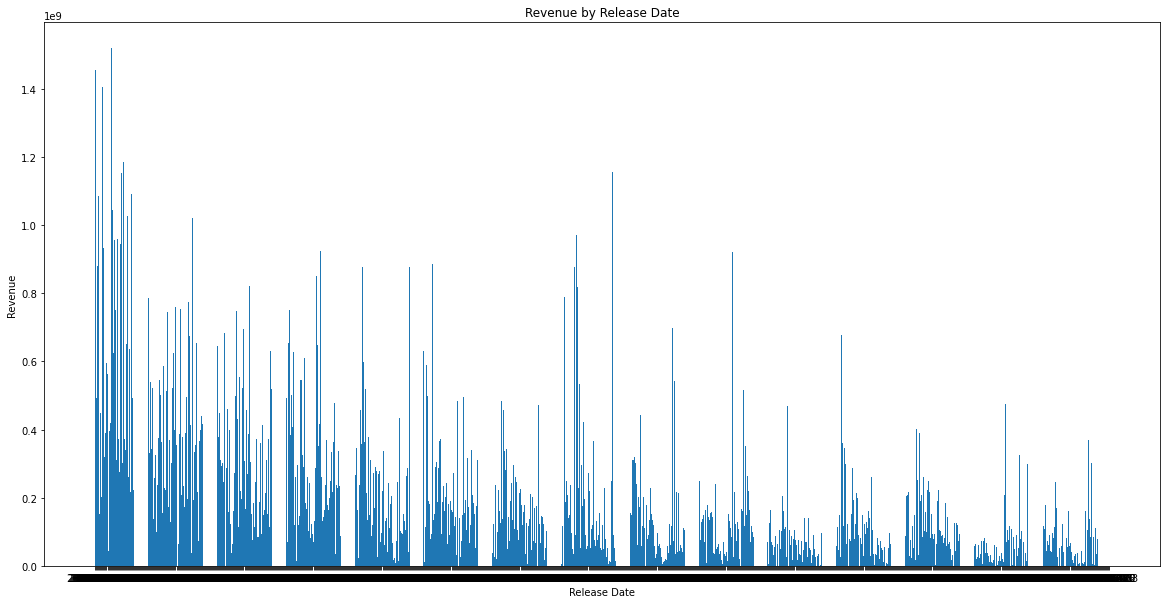

In [20]:
#visualize 1000 date
averageDS =[]
for index,values in enumerate(DateRe):
    averageDS.append(sum(DateRe[values])/len(DateRe[values]))
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(list(DateRe)[:1000],averageDS[:1000])
plt.xlabel('Release Date')
plt.ylabel('Revenue')
plt.title('Revenue by Release Date')
plt.show()

In [21]:
#hepothesis revevue and genres
f_oneway(DateRe[list(DateRe)[0]],DateRe[list(DateRe)[100]])

F_onewayResult(statistic=0.12058650035661916, pvalue=0.7872239148115118)

From above, we can't reject H0 and conclude that Release Date can not influent to Revenue

## Conclusion

From all, you can positive that Areas and Genres have impact to Revenue, Score_Average and Release_Date is not enough to say that it have influence to Revenue